# Autoencoder

A simple autoencoder to compress the MNIST dataset
![Autoencoder](assets/autoencoder_1.png)


In [32]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K


In [33]:
print(tf.__version__)

2.1.0


### Loading MNIST Dataset

In [44]:
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data() 

X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)
X_train = X_train.astype('float32')/ 255.
X_test = X_test.astype('float32')/255.

#y_train = to_categorical(y_train)
#y_test = to_categorical(y_test)



In [45]:
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


### Model Parameters

In [60]:
image_size = 28
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
layer_filters = [32, 64]

### Encoder

In [61]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# Stack of Conv2D(32)-Conv2D(64)

for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)
    
shape = K.int_shape(x)
    
# Latent Vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)
encoder = Model(inputs,
                latent,
                name='encoder')

encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_6 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


### Decoder 

In [62]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense((shape[1]*shape[2]*shape[3]))(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

# reconstruct the input
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 16)]              0         
_________________________________________________________________
dense_9 (Dense)              (None, 3136)              53312     
_________________________________________________________________
reshape_8 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_21 (Conv2DT (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_22 (Conv2DT (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 108,993
Trainable params: 108,993
Non-trainable params: 0
_____________________________________________________

### Autoencoder

In [53]:
autoencoder = Model(inputs,
                    decoder(encoder(inputs)),
                    name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Model)              (None, 16)                69008     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 65s 1ms/sample - loss: 0.0098 - val_loss: 0.0089


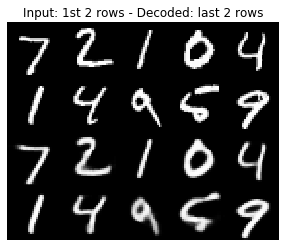

In [55]:
autoencoder.compile(loss='mse', optimizer='adam')

# train the autoencoder
autoencoder.fit(X_train,
                X_train,
                validation_data=(X_test, X_test),
                epochs=1,
                batch_size=batch_size)

# predict the autoencoder output from test data
X_output = autoencoder.predict(X_test)

# display the 1st 10 test input and decoded images
imgs = np.concatenate([X_test[:10], X_output[:10]])
imgs = imgs.reshape((4, 5, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Input: 1st 2 rows - Decoded: last 2 rows')
plt.imshow(imgs,cmap='gray')
plt.savefig('output.png')
plt.show()